In [50]:
import sys;sys.path.append(rf'D:\code\pywfn')  # noqa
import numpy as np
from pywfn.data import lebedev
import numpy as np
from pywfn import maths
from pywfn.maths import integ
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pyvista as pv
from sklearn.decomposition import PCA
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows: 黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

将一个原子固定在原点，遍历另一个原子的相对位置和相对角度，查看不同基函数的不同相对位置和相对角度时的重叠积分大小

原子1在坐标原点，原子2的位置使用lebdev的网格格点

原子1使用全局坐标系，原子2使用局部坐标系，局部坐标系的z轴在lebdev的网格上，剩下两个轴按z轴旋转遍历

In [2]:
angs=np.linspace(0,np.pi*2,36,endpoint=False)

rand_vect=np.random.rand(3) # 一个随机的单位向量
rand_vect/=np.linalg.norm(rand_vect)
print("随机单位向量",rand_vect)

datas=lebedev.LD0014()
grids=datas[:,:3]


ngrid=100
grids=[]
thes=np.linspace(0,np.pi,ngrid)
phis=np.linspace(0,np.pi*20,ngrid)%(np.pi*2)
zs=np.cos(thes)
xs=np.sin(thes)*np.cos(phis)
ys=np.sin(thes)*np.sin(phis)
grids=np.array([xs,ys,zs]).T

随机单位向量 [0.3206 0.8371 0.4432]


In [3]:
def sym2lmn(sym):
    match sym:
        case "s":return [0,0,0]
        case "px":return [1,0,0]
        case "py":return [0,1,0]
        case "pz":return [0,0,1]
        case _:return [0,0,0]


stm1=np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
],dtype=np.float64)
alps=[1.0,1.0]

def get_data(sym1:str,sym2:str):
    vals=[]
    vmat=np.zeros(shape=(ngrid,ngrid,36))
    for i,cent in enumerate(grids): # 对相对位置遍历
        x,y,z=cent
        xyzs=[[0.,0.,0.],[x,y,z]]
        for j,axis in enumerate(grids): # 对z轴方向进行遍历
            dirz=axis # z轴朝向
            dirx=np.cross(rand_vect,dirz) # x轴朝向
            diry=np.cross(dirx,dirz) # y轴朝向
            stm2=np.array([dirx,diry,dirz])
            for k,ang in enumerate(angs): # 对z轴旋转角度遍历
                stm2=maths.points_rotate(stm2,np.zeros(3),axis,ang)
                val=integ.local_gtf_integ(alps,xyzs,[sym1,sym2],stm1,stm2.T)
                vmat[i,j,k]=val
                vals.append(val)
    vals=np.array(vals)
    return vmat,vals

def get_paras(paras):
    the1,phi1,the2,phi2,ang=paras
    z1=np.cos(the1)
    x1=np.sin(the1)*np.cos(phi1)
    y1=np.sin(the1)*np.sin(phi1)
    xyzs=[
        [0.,0.,0.],[x1.item(),y1.item(),z1.item()]
    ]
    z2=np.cos(the2)
    x2=np.sin(the2)*np.cos(phi2)
    y2=np.sin(the2)*np.sin(phi2)
    dirz=np.array([x2,y2,z2])
    dirx=np.cross(rand_vect,dirz) # x轴朝向
    dirx=dirx/np.linalg.norm(dirx)
    diry=np.cross(dirx,dirz) # y轴朝向
    diry=diry/np.linalg.norm(diry)
    stm2=np.array([dirx,diry,dirz]).T
    stm2=maths.points_rotate(stm2,np.zeros(3),dirz,ang)
    return xyzs,stm2

def get_func(sym1:str,sym2:str):
    def func(paras):
        xyzs,stm2=get_paras(paras)
        val=integ.local_gtf_integ(alps,xyzs,[sym1,sym2],stm1,stm2)
        return val
    return func

In [4]:
syms=["PZ","PZ"]
xyzs=[[0.,0.,0.],[1.,0.,0.]]
stm2=np.array([
    [0,-1,0],
    [1,0,0],
    [0,0,1]
],dtype=float).T
dirz=np.array([0.,0.,1.])
ang=np.random.random()*np.pi*2
stm2=maths.points_rotate(stm2,np.zeros(3),dirz,ang)
print(stm2)
integ.local_gtf_integ(alps,xyzs,syms,stm1,stm2)

[[ 0.6881 -0.7257  0.    ]
 [ 0.7257  0.6881  0.    ]
 [ 0.      0.      1.    ]]


0.29851941595611464

测试函数是否连续，看起来是连续的

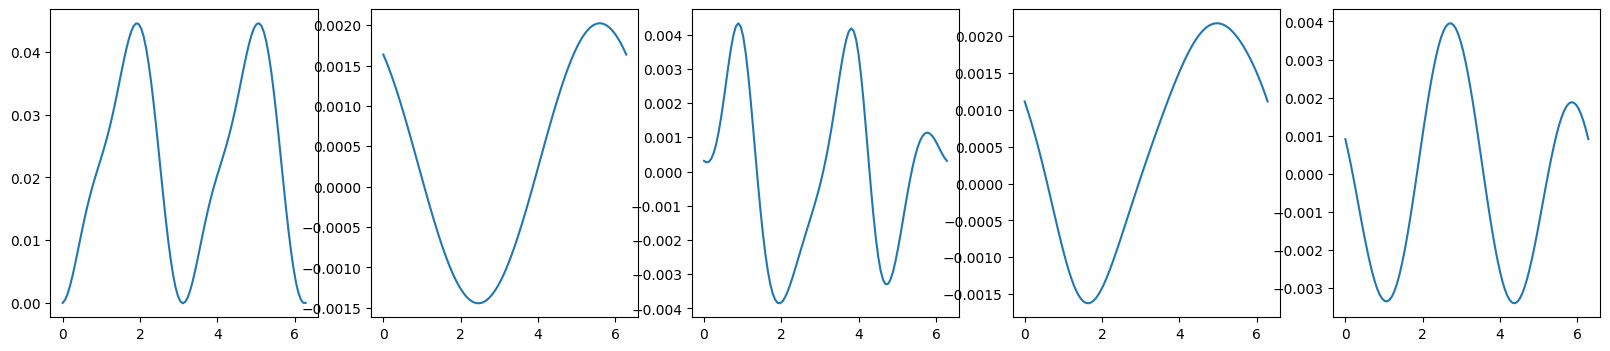

In [104]:
func=get_func("D+1","D+1")
paras=[np.pi/2,0.,0.,0.,0.]
paras=np.random.rand(5)
xyzs,stm2=get_paras(paras)
# print(xyzs[1])
# print(stm2)
# print(func(paras))
fig,axs=plt.subplots(1,5,figsize=(20,4))
angs=np.linspace(0,2*np.pi,100)
for i in range(5):
    new_paras=paras.copy()
    vals=[]
    for ang in angs:
        new_paras[i]=ang.item()
        val=func(new_paras)
        # if ang==0:
        #     print(new_paras,i,val)
        vals.append(val)
    axs[i].plot(angs,vals)
plt.show()

In [101]:
syms=["D+1","D+1"]
func=get_func(*syms)
def func2(paras):
    return func(paras)*-1


bound=[
    [0,np.pi*2],
    [0,np.pi*2],
    [0,np.pi*2],
    [0,np.pi*2],
    [0,np.pi*2],
]
# 
datas_raw=[]
datas_opt=[]
for i in range(1000):
    paras=(np.random.rand(5)*np.pi*2).tolist()

    result=minimize(func2,paras,bounds=bound)
    if not result.success:continue
    datas_opt.append(result.x.tolist()+[result.fun])
    datas_raw.append(paras+[func2(paras)])
datas_raw=np.array(datas_raw)
datas_opt=np.array(datas_opt)

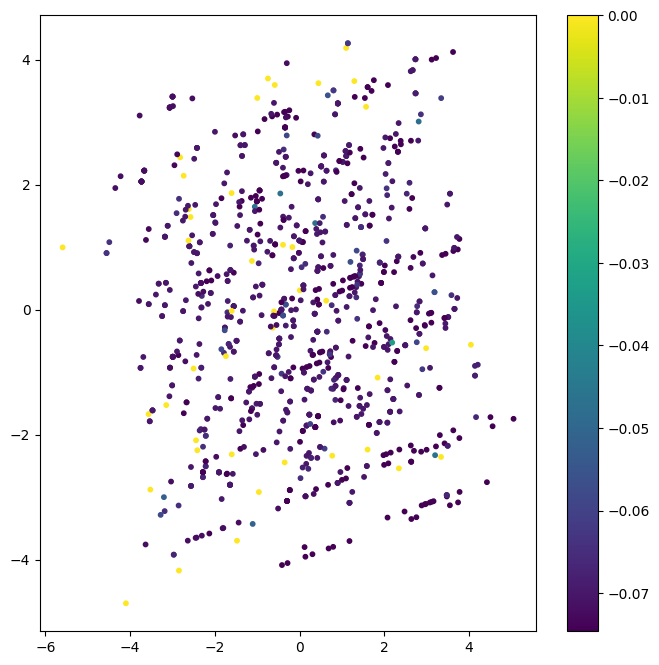

In [102]:
pca=PCA(n_components=2)
Fx=pca.fit_transform(datas_opt[:,:5])
fig,axs=plt.subplots(1,1,figsize=(8,8))
scatter=axs.scatter(Fx[:,0],Fx[:,1],c=datas_opt[:,-1],s=10)
fig.colorbar(scatter)
fig.savefig('成键研究.png',bbox_inches='tight',dpi=300)

Text(0.5, 1.0, 'opt')

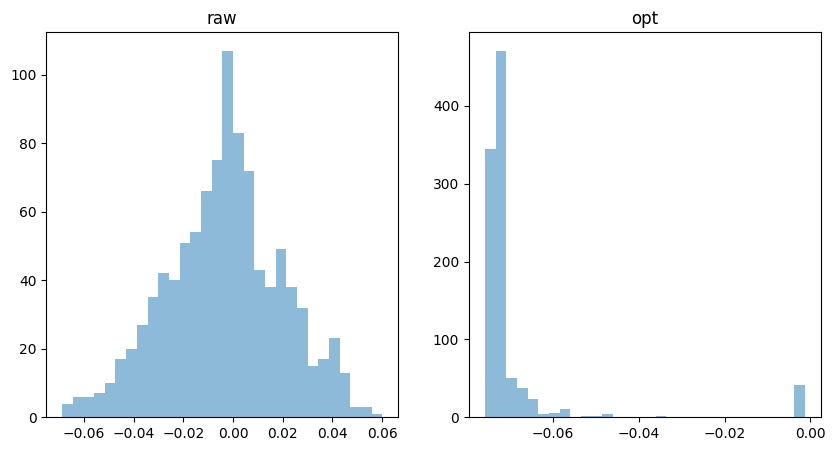

In [103]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
vals_raw, locs_raw = np.histogram(datas_raw[:,-1], bins=30)
vals_opt, locs_opt = np.histogram(datas_opt[:,-1], bins=30)


axs[0].bar(locs_raw[:-1], vals_raw, width=locs_raw[1]-locs_raw[0], alpha=0.5)
axs[1].bar(locs_opt[:-1], vals_opt, width=locs_opt[1]-locs_opt[0], alpha=0.5)
axs[0].set_title("raw")
axs[1].set_title("opt")

In [37]:
def f(paras):
    x,y=paras
    return -x**2+np.sin(y)
minimize(f,x0=[0,0],method='nelder-mead')

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -9.207047900415479e+82
             x: [ 3.034e+41 -3.599e+41]
           nit: 199
          nfev: 400
 final_simplex: (array([[ 3.034e+41, -3.599e+41],
                       [ 1.800e+41, -2.135e+41],
                       [ 1.067e+41, -1.266e+41]]), array([-9.207e+82, -3.238e+82, -1.139e+82]))

In [8]:
# 修改后的代码
pv.set_jupyter_backend('trame')
sphere = pv.Sphere(radius=0.1)
xyzs,stm2=get_paras(result.x)

# 使用RGB值而不是颜色名称
colors=np.array([
    [1.0, 0.0, 0.0],  # 红色
    [0.0, 1.0, 0.0],  # 绿色
    [0.0, 0.0, 1.0]   # 蓝色
])

# 创建绘图器
pl = pv.Plotter(notebook=True)
pl.add_mesh(sphere)

# 使用点云和glyph方法
cent=xyzs[1]
points = pv.PolyData(np.array([cent, cent, cent]))  # 三个点
points['vectors'] = stm2.T  # 每个点对应一个方向向量
# 为每个点分配颜色
points['colors'] = colors

# 创建箭头几何体
arrow_geom = pv.Arrow()
arrows = points.glyph(orient='vectors', scale=False, factor=0.3, geom=arrow_geom)

pl.add_mesh(arrows, scalars='colors', rgb=True) # type: ignore

# 对于单位矩阵的箭头
cent=np.zeros((3,3))
points2 = pv.PolyData(cent)  # 三个点在原点
points2['vectors'] = stm1  # 单位向量
points2['colors'] = colors

arrows2 = points2.glyph(orient='vectors', scale=False, factor=0.3, geom=arrow_geom)
pl.add_mesh(arrows2, scalars='colors', rgb=True) # type: ignore

pl.show()

Widget(value='<iframe src="http://localhost:4300/index.html?ui=P_0x1d3a79b2350_0&reconnect=auto" class="pyvist…

['YZ', 'YZ']


Text(0.5, 1.0, '基函绕全局z轴公转')

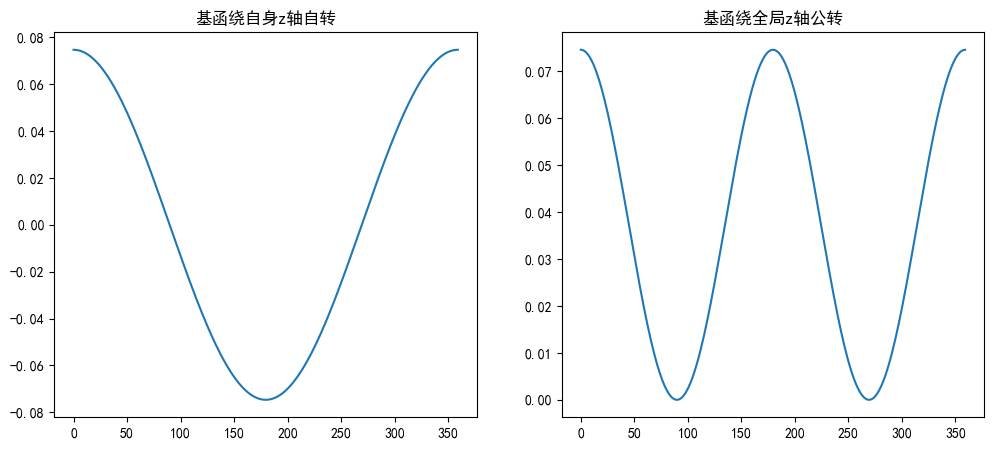

In [52]:
syms=["YZ","YZ"]
# syms.reverse()
print(syms)
alps=[1.,1.]
xyzs=[[0.,0.,0.],[1.,0.,0.]]

stm1=np.array([
    [1,0,0],
    [0,1,0],
    [0,0,1]
],dtype=np.float64)

angs=np.linspace(0,np.pi*2,360)
fig,axs=plt.subplots(1,2,figsize=(12,5))
vals=[]
for ang in angs:
    x=np.cos(ang)
    y=np.sin(ang)
    dx=[x,y,0]
    dy=[-y,x,0]
    dz=[0,0,1]
    stm2=np.array([dx,dy,dz]).T
    val=integ.local_gtf_integ(alps,xyzs,syms,stm1,stm2)
    vals.append(val)

axs[0].plot(vals)
axs[0].set_title("基函绕自身z轴自转")
vals=[]
for ang in angs:
    x=np.cos(ang)
    y=np.sin(ang)
    xyzs=[[0.,0.,0.],[x,y,0.]]
    val=integ.local_gtf_integ(alps,xyzs,syms,stm1,stm1)
    vals.append(val)

# print(vals)
axs[1].plot(vals)
axs[1].set_title("基函绕全局z轴公转")
# plt.plot(np.cos(angs))